/home/hchung/dotifs/py_etc/trans150626.dat
[ 0.832556  0.832556  0.832556 ...,  0.832556  0.832556  0.832556]
[ 3452.15838648  3632.41389104  3812.79921361 ...,  1605.41756032
  1605.67480758  1605.93205484] 1 / (J m)
[ 58.75507116  60.26951046  61.74786809 ...,  40.06766228  40.07087231
  40.07408208] 1 / (J(1/2) m(1/2))


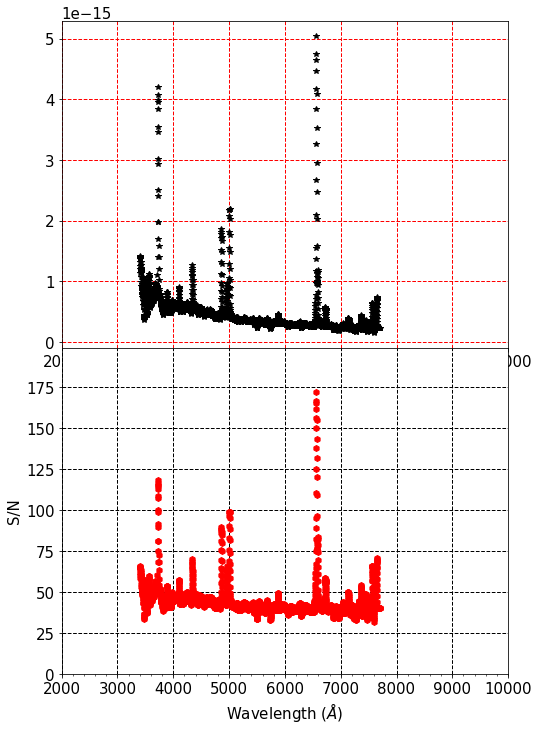

In [21]:
import numpy as np
import math
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
from astropy.constants import h, c
%matplotlib inline

class dotifs_etc(object):
    def __init__(self, exptime=900):
        pri=3.6
        sec=0.915
        flag=0
        use_asahi=1
        ltrghost=1
        
        telaream2=(pri**2-sec**2)/4*math.pi         #in m^2
        telarea=telaream2*1e4                           #in cm^2
        skysamplingsize=0.4**2*math.pi


        pixelscale=3700/3000   #angstrom/pixel
        dir='/home/hchung/dotifs/py_etc/'
        #dir='./'

        transfile=dir+'trans150626.dat'
        print(transfile)
        #data=ascii.read(transfile, format='no_header')
        tfile=ascii.read(transfile, data_start=1)
                #print(tfile['micron'])
        x=tfile['micron']
        y=tfile['cam']

        
        #plt.plot(x, y, 'o')
        #plt.show()
        #print(data)
        a=np.array(x)
        #print(a.ndim)
        #print(a.shape)
        #print(a)
        #print(tfile.shape)
        waveang=tfile['micron']*1e4
        
        wstep=3700/3000.

        nwave=int((waveang[-1]-waveang[0])/wstep)+1

        wave=np.linspace(0, nwave-1, num=nwave)*wstep+waveang[0]

        
        
        galtempfilename=dir+'kc96/'+'sc'+'_template.fits'
  
        galtempfile=fits.open(galtempfilename, memmap=True)
     
        galtemp=Table(galtempfile[1].data)
        galflam=galtemp['FLUX']
        galwave=galtemp['WAVELENGTH']
        
        sourceflux=np.interp(wave,galwave,galflam)*1e-2
        

        
        
        transtemp=np.interp(wave,tfile['micron']*1000,tfile['cam'])
        print(transtemp)
                
        photone=h*1e7*c/(wave*1e-10)

        sourcecount=(sourceflux/photone)*wstep*telarea*exptime*skysamplingsize
        print(sourcecount)
        
        signal=sourcecount
        noise=signal**0.5
        
        snr=signal/noise
        print(snr)
        
        matplotlib.rcParams.update({'font.size':15})
        font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}

        matplotlib.rc('font', **font)
        
        plt.clf
        fig=plt.figure(figsize=(8,12))
        #gs1=matplotlib.gridspec.GridSpec(8,12)
        gs1=gridspec.GridSpec(2,1)
        gs1.update(hspace=0)
        
        #ax=plt.subplot(211)
        ax0=plt.subplot(gs1[0])
        ax0.plot(wave, sourceflux, 'k*')
        #ax=plt.subplot(212)
        ax=plt.subplot(gs1[1])
        ax.plot(wave, snr, 'rh')
        #ax.set_ylabel("S/N", fontsize=20)
        #ax.set_xlabel("Wavelength $\AA$ ", fontsize=20)
        ax.set_ylabel("S/N")
        ax.set_xlabel("Wavelength ($\AA$) ")
        ax.grid(b=True, which='major', color='k', linestyle='--', linewidth=1)
        ax.xaxis.set_minor_locator(plt.MultipleLocator(200))
        #ax.xlim([2000,10000])
        xlim=[2000,10000]
        ylim=[0,199]
        
        ax.set_xlim(xlim)
        ax0.grid(b=True, which='major', color='r', linestyle='--', linewidth=1)
        ax0.set_xlim(xlim)
        ax.set_ylim(ylim)
        
        '''
        plt.subplot(231)
        plt.subplot(236)
        plt.subplot(235)
        plt.subplot(234)
        '''
        #plt.scatter(wave, snr)
        
def codetest():
    dotifs_etc(300)
#!cat ~/dotifs_etc/trans150626.dat
codetest()